# Introduction to Deep Learning: Cours-1
_Adapted from [Dataflowr Module 1](https://dataflowr.github.io/website/modules/1-intro-general-overview/) by Marc Lelarge_

Let's start with an existing model for one of the most popular task in machine learning: image classification.
In this notebook, we focus on the [Dogs vs Cats competition](https://www.kaggle.com/c/dogs-vs-cats) at Kaggle.

## System setup

Import the required packages, check the current version of PyTorch, and check that GPU is available (on Colab you may need to change the runtime first).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
import torch

device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"{torch.__version__=}")
print(f"Using {device=}")


torch.__version__='2.9.1'
Using device='mps'


## Download the dataset

There are 25,000 labeled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle website, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". So if you can beat 80%, then you will be at the cutting edge as of 2013!

Jeremy Howard (fast.ai) provides a direct link to the dogscats dataset. He's separated the cats and dogs into separate folders and created a validation folder.

In [2]:
%mkdir data
# the following line should be modified if you run the notebook on your computer
# change directory to data where you will store the dataset
%cd data/ #%cd /content/data/
!wget http://files.fast.ai/data/examples/dogscats.tgz

[Errno 2] No such file or directory: 'data/ #%cd /content/data/'
/Users/gbaudart/Cours/m2-idl/2025-m2-idl/1-introduction
--2026-01-12 10:46:17--  http://files.fast.ai/data/examples/dogscats.tgz
Resolving files.fast.ai (files.fast.ai)... 172.67.69.159, 104.26.2.19, 104.26.3.19, ...
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/examples/dogscats.tgz [following]
--2026-01-12 10:46:17--  https://files.fast.ai/data/examples/dogscats.tgz
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839285364 (800M) [application/x-gtar-compressed]
Saving to: ‘dogscats.tgz’

dogscats.tgz        100%[===================>] 800.40M  9.94MB/s    in 84s     

2026-01-12 10:47:41 (9.54 MB/s) - ‘dogscats.tgz’ saved [839285364/839285364]



In [3]:
!tar -zxvf dogscats.tgz
%cd dogscats/

x dogscats/
x dogscats/sample/
x dogscats/sample/train/
x dogscats/sample/train/cats/
x dogscats/sample/train/cats/cat.2921.jpg
x dogscats/sample/train/cats/cat.394.jpg
x dogscats/sample/train/cats/cat.4865.jpg
x dogscats/sample/train/cats/cat.3570.jpg
x dogscats/sample/train/cats/cat.2266.jpg
x dogscats/sample/train/cats/cat.9021.jpg
x dogscats/sample/train/cats/cat.11737.jpg
x dogscats/sample/train/cats/cat.4600.jpg
x dogscats/sample/train/dogs/
x dogscats/sample/train/dogs/dog.1402.jpg
x dogscats/sample/train/dogs/dog.1614.jpg
x dogscats/sample/train/dogs/dog.8643.jpg
x dogscats/sample/train/dogs/dog.6391.jpg
x dogscats/sample/train/dogs/dog.2423.jpg
x dogscats/sample/train/dogs/dog.9077.jpg
x dogscats/sample/train/dogs/dog.8091.jpg
x dogscats/sample/train/dogs/dog.6768.jpg
x dogscats/sample/valid/
x dogscats/sample/valid/cats/
x dogscats/sample/valid/cats/cat.10435.jpg
x dogscats/sample/valid/cats/cat.4319.jpg
x dogscats/sample/valid/cats/cat.5202.jpg
x dogscats/sample/valid/cats/c

Here is the file tree of `dogscats`:
```bash
.
├── test1 # contains 12500 images of cats and dogs
├── train
|   └── cats # contains 11500 images of cats
|   └── dogs # contains 11500 images of dogs
├── valid
|   └── cats # contains 1000 images of cats
|   └── dogs # contains 1000 images of dogs
├── sample
|   └── train
|       └── cats # contains 8 images of cats
|       └── dogs # contains 8 images of dogs    
|   └── valid 
|       └── cats # contains 4 images of cats
|       └── dogs # contains 4 images of dogs    
├── models # empty folder
```

12,500 images are in the `test1` sub-folder; the dataset of 25,000 labeled images has been split into a training set and a validation set.

The sub-folder `sample` is here only to make sure the code is running properly on a very small dataset.

In [4]:
%cd ..

/Users/gbaudart/Cours/m2-idl/2025-m2-idl/1-introduction


## Data processing

In [5]:
data_dir = './dogscats' # modify if needed

`datasets` is a class defined in the `torchvision` package (see [torchvision.datasets](http://pytorch.org/docs/master/torchvision/datasets.html)) for data loading. It integrates a multi-threaded loader that fetches images from the disk, groups them in mini-batches and serves them continuously to the GPU right after each _forward_/_backward_ pass through the network.

Images need a bit of preparation before passing them through the network. They need to all have the same size $224\times 224 \times 3$ plus some extra formatting done below by the normalize transform (explained later).

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

imagenet_format = transforms.Compose([
                transforms.CenterCrop(224), # Crop the image to 224 px
                transforms.ToTensor(), # Convert to Torch tensors
                normalize, # Normalize
            ])

In [7]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), imagenet_format)
         for x in ['train', 'valid']}

We used `datasets.ImageFolder` to load the datasets. Let's look at this class.

In [8]:
?datasets.ImageFolder

Init signature:
datasets.ImageFolder(
    root: Union[str, pathlib.Path],
    transform: Optional[Callable] = None,
    target_transform: Optional[Callable] = None,
    loader: Callable[[str], Any] = <function default_loader at 0x11e46ab60>,
    is_valid_file: Optional[Callable[[str], bool]] = None,
    allow_empty: bool = False,
)
Docstring:     
A generic data loader where the images are arranged in this way by default: ::

    root/dog/xxx.png
    root/dog/xxy.png
    root/dog/[...]/xxz.png

    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/[...]/asd932_.png

This class inherits from :class:`~torchvision.datasets.DatasetFolder` so
the same methods can be overridden to customize the dataset.

Args:
    root (str or ``pathlib.Path``): Root directory path.
    transform (callable, optional): A function/transform that takes in a PIL image or torch.Tensor, depends on the given loader,
        and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (c

We see that `datasets.ImageFolder` has attributes: classes, class_to_idx, imgs.

Let's see what they are.

In [9]:
dset_classes = dsets['train'].classes
dset_classes

['cats', 'dogs']

The names of the classes are directly inferred from the structure of the folder:
```bash
├── train
|   └── cats
|   └── dogs
```

In [10]:
dsets['train'].class_to_idx

{'cats': 0, 'dogs': 1}

Label 0 corresponds to cats and 1 to dogs.

We can see that the first 5 elements of the train dataset are pairs (location_of_the_image, label): 

In [11]:
dsets['train'].imgs[:5]

[('./dogscats/train/cats/cat.0.jpg', 0),
 ('./dogscats/train/cats/cat.1.jpg', 0),
 ('./dogscats/train/cats/cat.10.jpg', 0),
 ('./dogscats/train/cats/cat.100.jpg', 0),
 ('./dogscats/train/cats/cat.1000.jpg', 0)]

In [12]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}
dset_sizes

{'train': 23000, 'valid': 2000}

As expected, we have 23,000 images in the training set and 2,000 in the validation set.

The `torchvision` packages allows complex pre-processing/transforms of the input data (_e.g._ normalization, cropping, flipping, jittering). A sequence of transforms can be grouped in a pipeline with the help of the `torchvision.transforms.Compose` function, see [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html).

The magic help `?` allows you to retrieve function you defined and forgot!

In [13]:
?imagenet_format

Signature:   imagenet_format(img)
Type:        Compose
String form:
Compose(
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
File:        ~/Cours/m2-idl/2025-m2-idl/.venv/lib/python3.12/site-packages/torchvision/transforms/transforms.py
Docstring:  
Composes several transforms together. This transform does not support torchscript.
Please, see the note below.

Args:
    transforms (list of ``Transform`` objects): list of transforms to compose.

Example:
    >>> transforms.Compose([
    >>>     transforms.CenterCrop(10),
    >>>     transforms.PILToTensor(),
    >>>     transforms.ConvertImageDtype(torch.float),
    >>> ])

.. note::
    In order to script the transformations, please use ``torch.nn.Sequential`` as below.

    >>> transforms = torch.nn.Sequential(
    >>>     transforms.CenterCrop(10),
    >>>     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    >>> )
    >>> scripted_transforms =

Where do this normalization and the magic constants for `mean` and `std` come from?

As explained in the [PyTorch doc](https://pytorch.org/docs/stable/torchvision/models.html), you will use a pretrained model. All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

We can now define 2 dataloaders for the train and valid datasets using the `DataLoader` class.

In [14]:
loader_train = torch.utils.data.DataLoader(dsets['train'], batch_size=64, shuffle=True, num_workers=6)
loader_valid = torch.utils.data.DataLoader(dsets['valid'], batch_size=5, shuffle=False, num_workers=6)

In [15]:
?torch.utils.data.DataLoader

Init signature:
torch.utils.data.DataLoader(
    dataset: 'Dataset[_T_co]',
    batch_size: 'Optional[int]' = 1,
    shuffle: 'Optional[bool]' = None,
    sampler: 'Union[Sampler, Iterable, None]' = None,
    batch_sampler: 'Union[Sampler[list], Iterable[list], None]' = None,
    num_workers: 'int' = 0,
    collate_fn: 'Optional[_collate_fn_t]' = None,
    pin_memory: 'bool' = False,
    drop_last: 'bool' = False,
    timeout: 'float' = 0,
    worker_init_fn: 'Optional[_worker_init_fn_t]' = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: 'Optional[int]' = None,
    persistent_workers: 'bool' = False,
    pin_memory_device: 'str' = '',
    in_order: 'bool' = True,
) -> 'None'
Docstring:     
Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loading, customizing
loading order and o

In [16]:
count = len(loader_valid)
inputs_try, labels_try = next(iter(loader_valid))

In [17]:
labels_try

tensor([0, 0, 0, 0, 0])

In [18]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

The validation dataset contains 2,000 images, hence there are 400 batches of size 5. `labels_try` contains the labels of the first batch and `inputs_try` contains the images of the first batch.
But what is an image here?

In [19]:
inputs_try[0]

tensor([[[ 1.1872,  1.1358,  1.0844,  ..., -1.4672, -1.4500, -1.4329],
         [ 1.0673,  1.0159,  0.9817,  ..., -1.4329, -1.4158, -1.3987],
         [ 0.9474,  0.9132,  0.8961,  ..., -1.4329, -1.4329, -1.4329],
         ...,
         [-1.6042, -1.5870, -1.5528,  ...,  0.8447,  0.7933,  0.7077],
         [-1.5528, -1.5870, -1.5699,  ...,  0.9303,  0.8961,  0.8618],
         [-1.5185, -1.5357, -1.5357,  ...,  0.9132,  0.8276,  0.8104]],

        [[ 0.8004,  0.7479,  0.6954,  ...,  0.8880,  0.9055,  0.9230],
         [ 0.6779,  0.6254,  0.5903,  ...,  0.9230,  0.9405,  0.9580],
         [ 0.5553,  0.5203,  0.5028,  ...,  0.9230,  0.9230,  0.9230],
         ...,
         [ 0.8529,  0.8704,  0.8880,  ...,  0.3978,  0.3452,  0.2927],
         [ 0.9580,  0.9230,  0.8880,  ...,  0.5203,  0.4853,  0.4678],
         [ 0.9930,  0.9755,  0.9230,  ...,  0.5203,  0.4678,  0.4503]],

        [[ 0.2173,  0.1651,  0.1128,  ...,  0.1128,  0.1302,  0.1476],
         [ 0.0953,  0.0431,  0.0082,  ...,  0

A 3-channel RGB image has shape (3 x H x W). Note that entries can be negative because of the normalization.

In [20]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

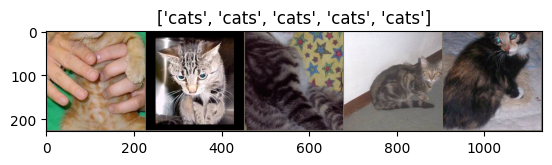

In [21]:
# Make a grid from batch from the validation data
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

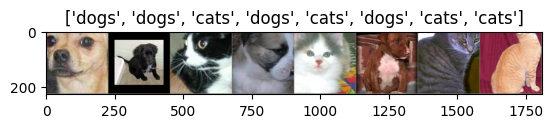

In [22]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## The VGG model

The torchvision module comes with a zoo of popular CNN architectures that are already trained on [ImageNet](http://www.image-net.org/) (1.2M training images). When called for the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`.
For subsequent calls, the model will be directly read from there.

In [23]:
model_vgg = models.vgg16(weights='DEFAULT')

We will first use the VGG model without any modification. In order to interpret the results, we need to import the 1,000 ImageNet categories, available at: [https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json](https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json)

In [24]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2026-01-12 10:48:25--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.191.22, 16.182.100.152, 52.217.135.248, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.191.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json.2’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.1s    

2026-01-12 10:48:25 (350 KB/s) - ‘imagenet_class_index.json.2’ saved [35363/35363]



In [25]:
import json

fpath = 'imagenet_class_index.json'

with open(fpath) as f:
    class_dict = json.load(f)
dic_imagenet = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [26]:
dic_imagenet[:4]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark']

Now let's try to run the model on our small input, and see the results.

Note: In PyTorch, we need to transfer the input tensors to the device to use the GPU.

In [27]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [28]:
outputs_try = model_vgg(inputs_try)

In [29]:
outputs_try

tensor([[ 1.6228, -0.5129,  0.0149,  ...,  4.0613,  4.1348,  1.4330],
        [-2.5116,  1.7979, -3.5863,  ..., -5.6330,  4.7691,  4.9832],
        [-2.5738, -2.0810, -0.1422,  ..., -2.8161,  0.3378,  3.1732],
        [-2.0071, -0.0248,  1.5324,  ..., -4.7111, -0.9260,  3.6215],
        [-3.4488, -3.1653, -3.4510,  ..., -4.4500,  3.3731,  4.1595]],
       device='mps:0', grad_fn=<LinearBackward0>)

In [30]:
outputs_try.shape

torch.Size([5, 1000])

To translate the outputs of the network into 'probabilities', we pass it through a [Softmax function](https://en.wikipedia.org/wiki/Softmax_function)

In [31]:
m_softm = nn.Softmax(dim=1)
probs = m_softm(outputs_try)
vals_try,preds_try = torch.max(probs,dim=1)

Let's check that we obtain probabilities!

In [32]:
torch.sum(probs,1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='mps:0',
       grad_fn=<SumBackward1>)

In [33]:
vals_try

tensor([0.2936, 0.4997, 0.5332, 0.7886, 0.2912], device='mps:0',
       grad_fn=<MaxBackward0>)

The predictions correspond to the labels of the ImageNet categories.

In [34]:
print(preds_try)
print([dic_imagenet[i] for i in preds_try.data])

tensor([333, 281, 281, 281, 283], device='mps:0')
['hamster', 'tabby', 'tabby', 'tabby', 'Persian_cat']


Here are the predictions (label with maximum probability) and the corresponding images.

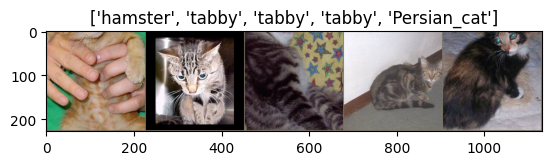

In [35]:
out = torchvision.utils.make_grid(inputs_try.data.cpu())

imshow(out, title=[dic_imagenet[i] for i in preds_try.data])

## Modify the last layer and freeze the rest

Let's look at the current model.

In [36]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

![vgg16](imgs/vgg.png)

In this practical example, our goal is to use the already trained model and just change the number of output classes. To this end, we replace the last `nn.Linear` layer trained for 1,000 classes with one with 2 classes. In order to freeze the weights of the other layers during training, we set the field `requires_grad=False`. In this manner, no gradient will be computed for them during backprop and hence no update to the weights. Only the weights for the 2-class layer will be updated.

In [37]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 2)

PyTorch documentation for [LogSoftmax](https://pytorch.org/docs/stable/nn.html#logsoftmax)

In [38]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [39]:
model_vgg = model_vgg.to(device)

## Training the new Layer

### Creating loss function and optimizer

We choose a loss function for our classification task.
The loss is the objective function we are trying to minimize during training.
PyTorch documentation for [CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.loss.CrossEntropyLoss.html) and the [torch.optim module](https://docs.pytorch.org/docs/stable/optim.html).

In [40]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

We can now train our model to minimize the loss.
This is a classic training loop:
For each batch:
- Execute the forward pass to compute the output of the network
- Compute the loss using the output and the expected value
- Execute the backward pass to compute the gradients
- Update the parameters

Repeat the entire process for several epochs (passes over the full dataset).

In [41]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            inputs, classes = inputs.to(device), classes.to(device) # move to GPU
            outputs = model(inputs) # forward pass
            loss = criterion(outputs,classes) # loss
            optimizer.zero_grad()
            loss.backward() # backward pass
            optimizer.step() # update
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [42]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['train'],epochs=2,optimizer=optimizer_vgg)

Loss: 0.0023 Acc: 0.9518
Loss: 0.0013 Acc: 0.9704
CPU times: user 4.62 s, sys: 2.24 s, total: 6.87 s
Wall time: 3min 49s


It is now time to test our new model. The following test function iterates over a dataset batch by batch, but we do not execute a backward pass or update the parameters.

In [43]:
def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,2))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = m_softm(outputs.data).to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [44]:
%%time

predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['valid'])

Loss: 0.0124 Acc: 0.9810
CPU times: user 1.46 s, sys: 457 ms, total: 1.91 s
Wall time: 39.8 s


Let's visualize a few results in the validation set.

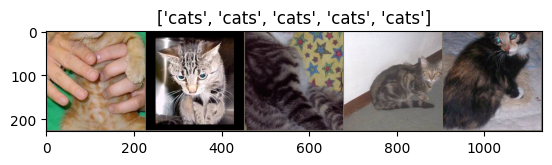

In [45]:
inputs, classes = next(iter(loader_valid))

n_images = 7

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

As with the original VGG model, we can convert the output of the network into probabilities using a softmax.

In [46]:
outputs = model_vgg(inputs[:n_images].to(device))
print(m_softm(outputs))

tensor([[8.9713e-01, 1.0287e-01],
        [9.9997e-01, 2.8697e-05],
        [9.9090e-01, 9.0985e-03],
        [9.9951e-01, 4.8735e-04],
        [9.8831e-01, 1.1685e-02]], device='mps:0', grad_fn=<SoftmaxBackward0>)


## Model predictions

The most important metrics for us to look at are for the validation set, since we want to check for over-fitting.

With our first model, we should try to overfit before we start worrying about how to handle that - there's no point even thinking about regularization, data augmentation, etc. if you're still underfitting!

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:

   1. A few correct labels at random
   2. A few incorrect labels at random
   3. The most correct labels of each class (ie those with highest probability that are correct)
   4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
   5. The most uncertain labels (ie those with probability closest to 0.5).

In general, these are particularly useful for debugging problems in the model. Since our model is very simple, there may not be too much to learn at this stage...

In [47]:
# Number of images to view for each visualization task
n_view = 8

### 1. Correct predictions

First, let's compute the overall accuracy on the validation set.

In [48]:
correct = np.where(predictions==all_classes)[0]
len(correct)/dset_sizes['valid']

0.981

Our model achieves 97.9% accuracy! Let's look at a few random correct predictions.

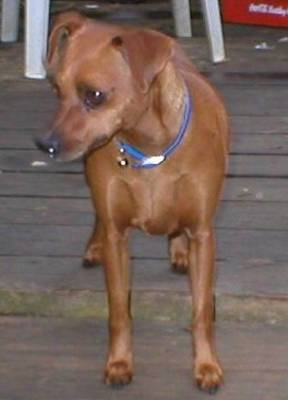

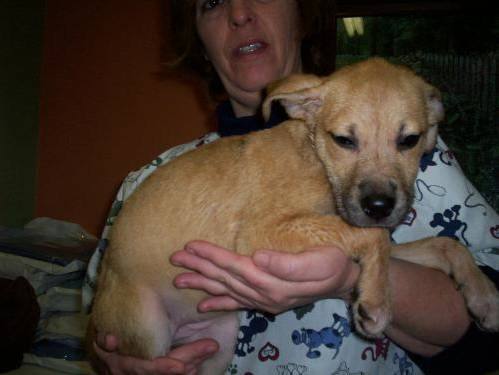

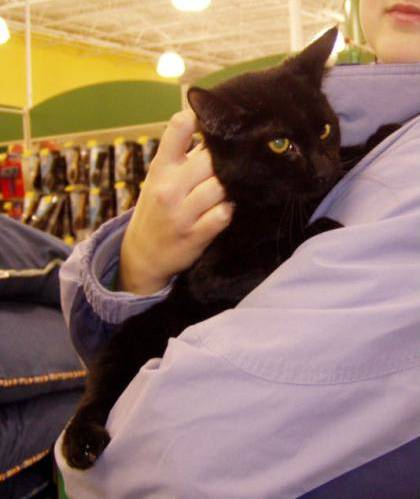

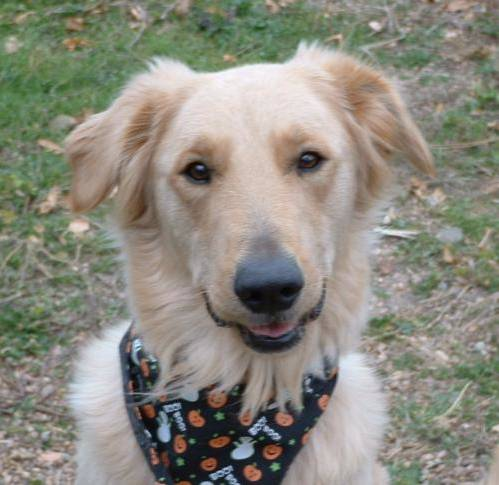

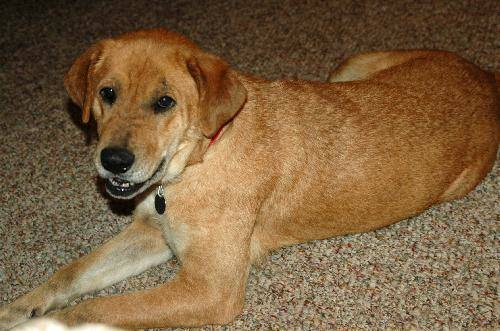

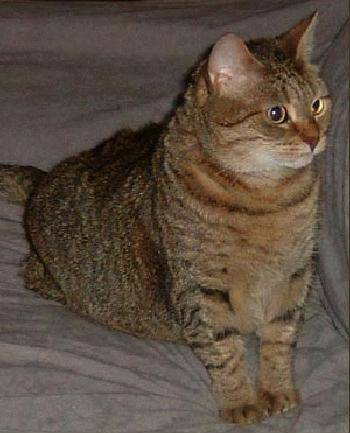

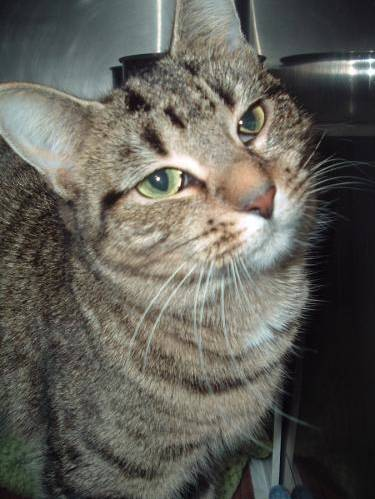

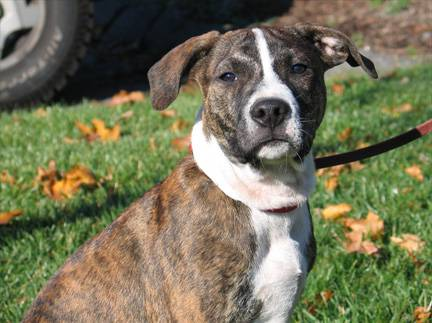

In [49]:
from numpy.random import permutation
from IPython.display import Image, display
for x in permutation(correct)[:n_view]:
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

### 2. Incorrect predictions

Now let's examine some incorrect predictions to understand where the model fails.

0 1.0


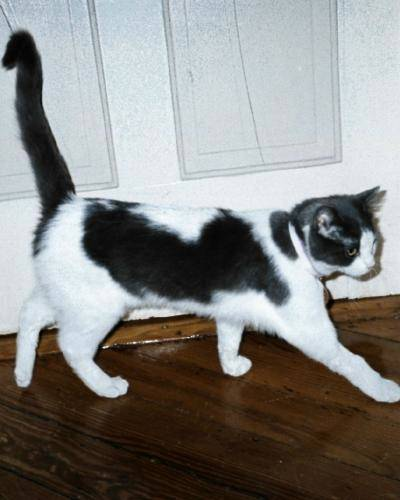

0 1.0


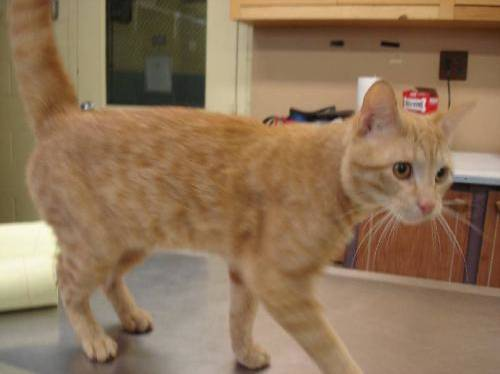

1 0.0


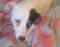

0 1.0


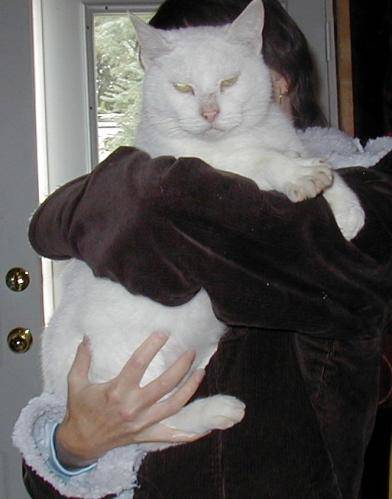

0 1.0


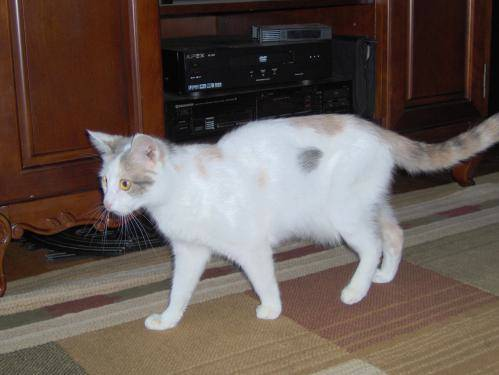

1 0.0


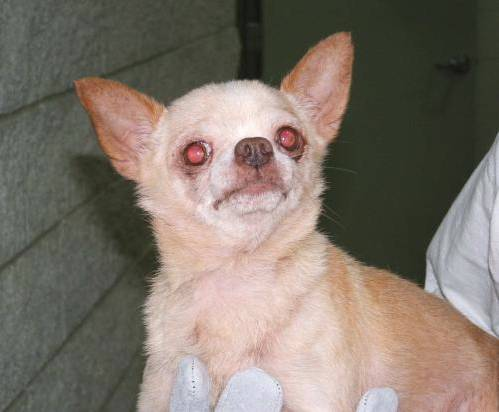

0 1.0


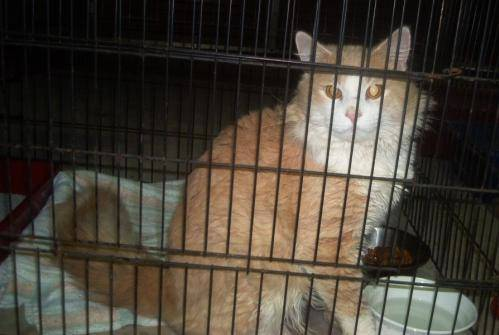

0 1.0


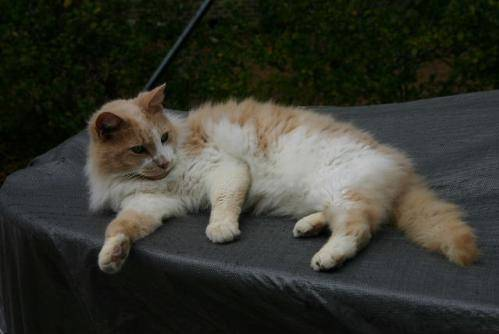

In [50]:
incorrect = np.where(predictions!=all_classes)[0]
for x in permutation(incorrect)[:n_view]:
    print(dsets['valid'].imgs[x][1], predictions[x])
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

### 3. Most confident correct predictions

We now look at the predictions where the model was most confident and correct. For cats, we sort by probability of class 0 (ascending order means lowest probability = highest confidence after we reverse).

0 0.0 0.9999990463256836


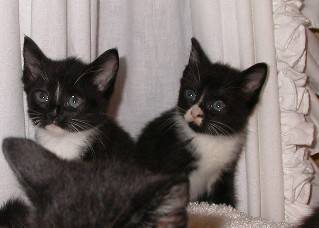

0 0.0 0.9999986886978149


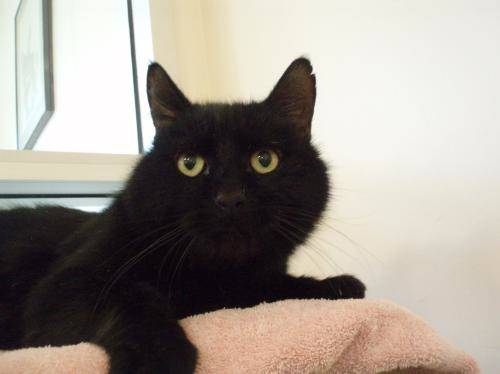

0 0.0 0.9999983310699463


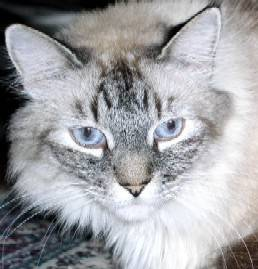

0 0.0 0.9999980926513672


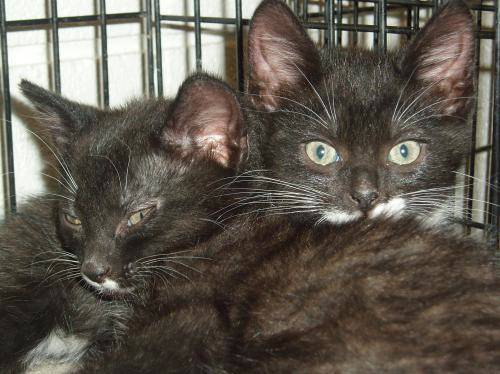

0 0.0 0.999997615814209


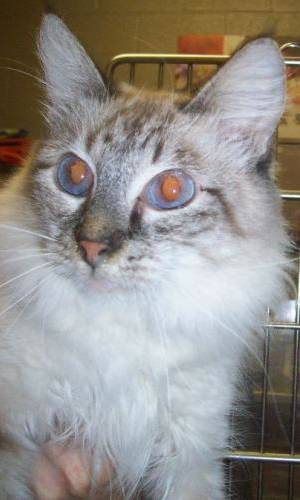

0 0.0 0.9999970197677612


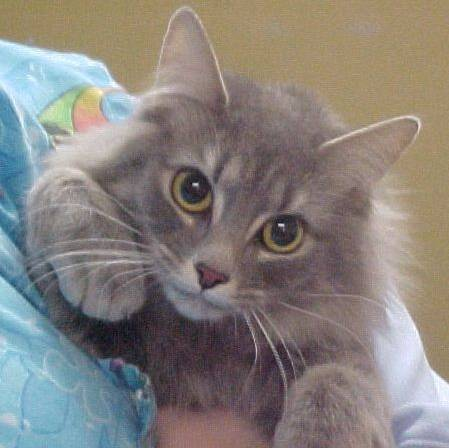

0 0.0 0.9999961853027344


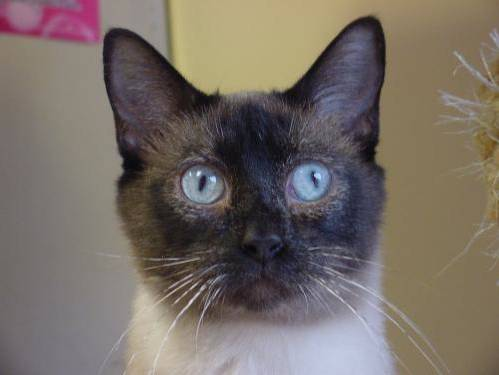

0 0.0 0.9999959468841553


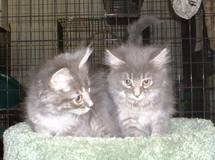

In [51]:
correct_cats = np.where((predictions==0) & (predictions==all_classes))[0]
most_correct_cats = np.argsort(- all_proba[correct_cats,0])[:n_view]

for x in most_correct_cats:
    print(dsets['valid'].imgs[correct_cats[x]][1], predictions[correct_cats[x]], all_proba[correct_cats,0][x])
    display(Image(filename=dsets['valid'].imgs[correct_cats[x]][0], retina=True))

Similarly, we can look at the images the model was most confident were dogs.

1 1.0 0.9999815225601196


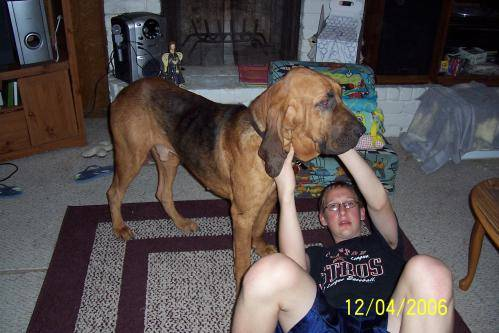

1 1.0 0.9999790191650391


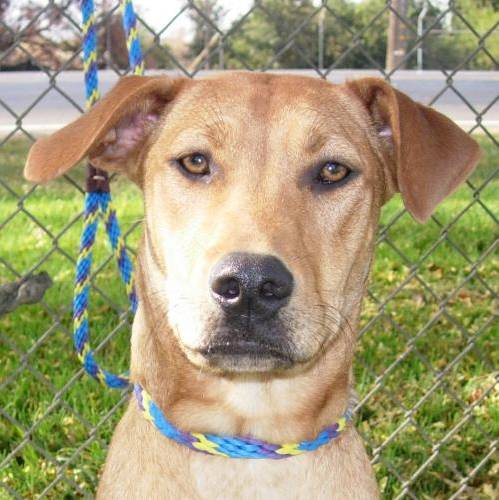

1 1.0 0.9999744892120361


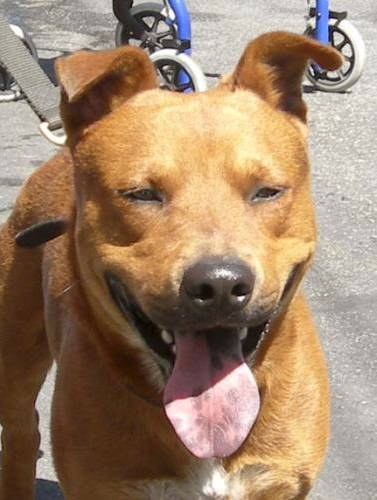

1 1.0 0.9999467134475708


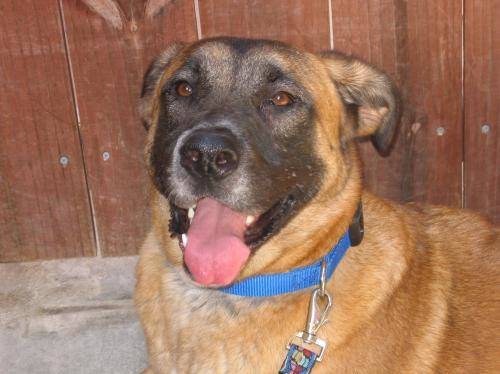

1 1.0 0.9999179840087891


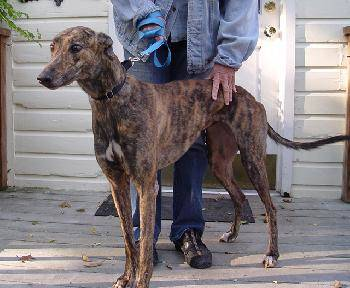

1 1.0 0.9999160766601562


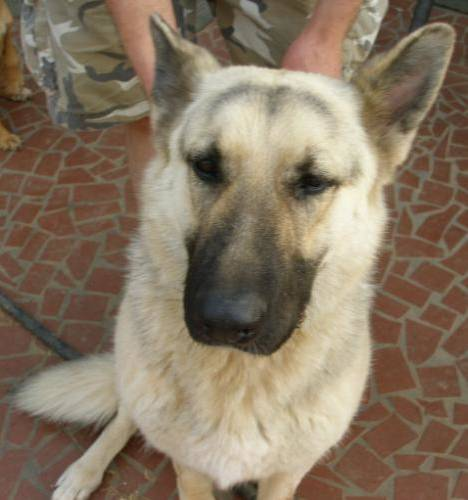

1 1.0 0.9999148845672607


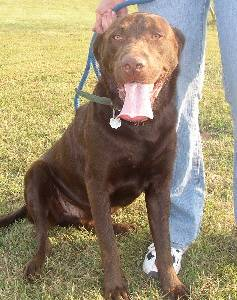

1 1.0 0.9999057054519653


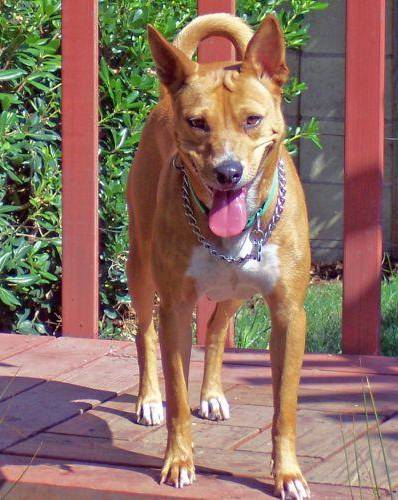

In [52]:
correct_dogs = np.where((predictions==1) & (predictions==all_classes))[0]
most_correct_dogs = np.argsort(- all_proba[correct_dogs,1])[:n_view]

for x in most_correct_dogs:
    print(dsets['valid'].imgs[correct_dogs[x]][1], predictions[correct_dogs[x]], all_proba[correct_dogs,1][x])
    display(Image(filename=dsets['valid'].imgs[correct_dogs[x]][0], retina=True))

### 4. Most confident incorrect predictions (most wrong)

Now, these are the images where the model was very confident but wrong. We look for images predicted as cats (class 0) but which are actually dogs (class 1).

1 0.0 0.8690018057823181


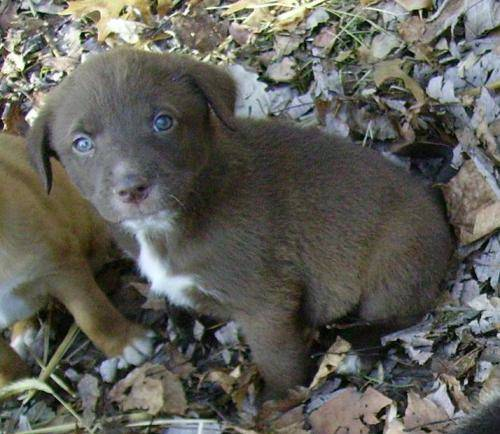

1 0.0 0.7789245843887329


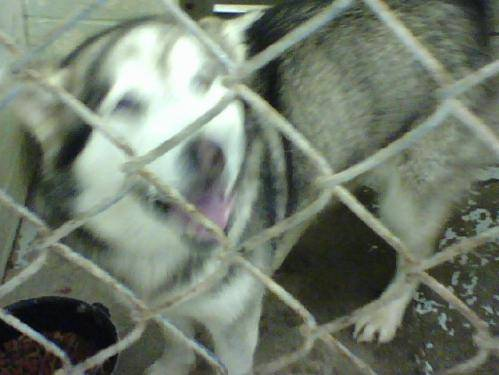

1 0.0 0.7589107751846313


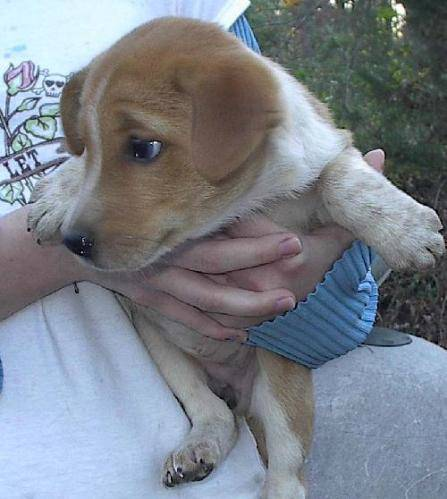

1 0.0 0.7444469332695007


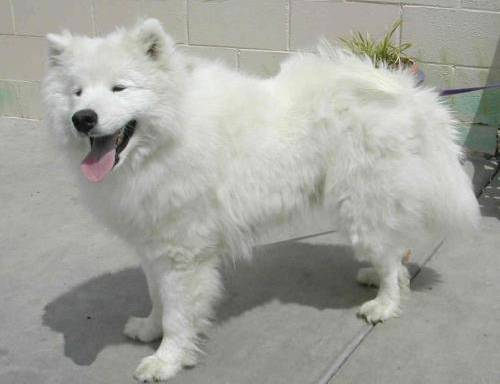

1 0.0 0.7362109422683716


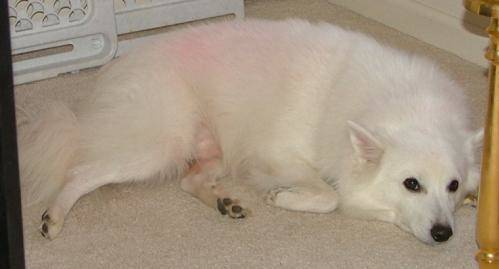

1 0.0 0.6927099227905273


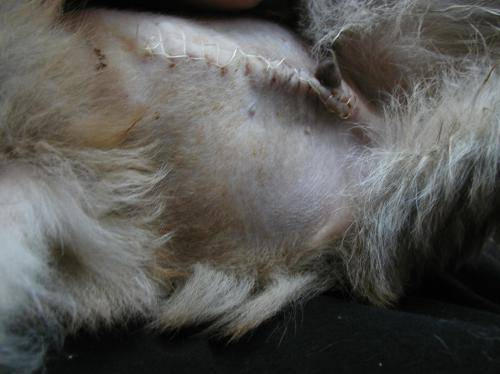

1 0.0 0.6717981696128845


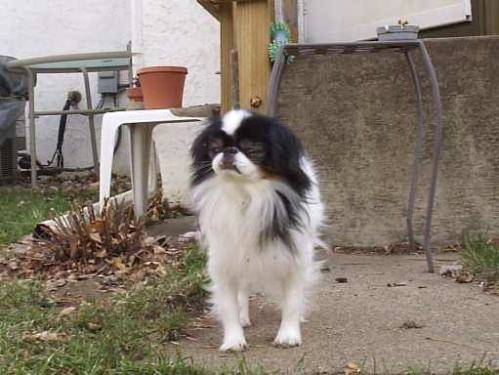

1 0.0 0.6595357060432434


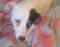

In [53]:
incorrect_cats = np.where((predictions==0) & (predictions!=all_classes))[0]
most_incorrect_cats = np.argsort(-all_proba[incorrect_cats, 0])[:n_view]

for x in most_incorrect_cats:
    print(dsets['valid'].imgs[incorrect_cats[x]][1], predictions[incorrect_cats[x]], all_proba[incorrect_cats, 0][x])
    display(Image(filename=dsets['valid'].imgs[incorrect_cats[x]][0], retina=True))

### 5. Most uncertain predictions

Finally, let's look at the predictions where the model was most uncertain. These are images where the probability is closest to 0.5 (the model cannot decide between cat and dog).

0 [0.50303316 0.49696681]


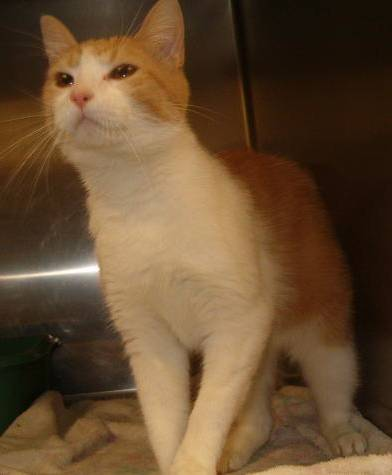

0 [0.4950144  0.50498557]


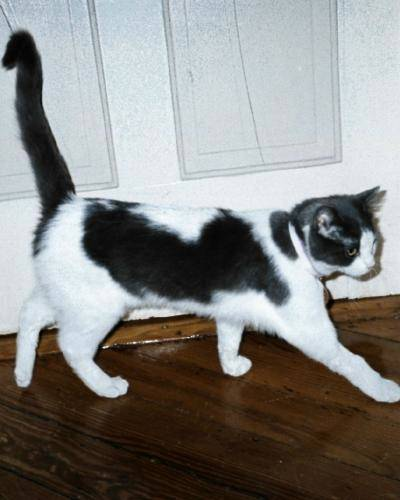

0 [0.50904787 0.49095216]


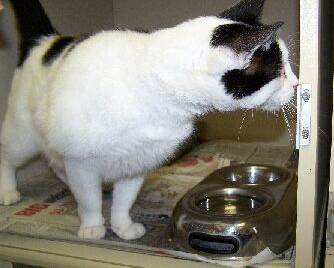

1 [0.49076188 0.50923812]


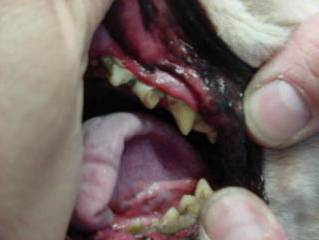

1 [0.48980099 0.51019907]


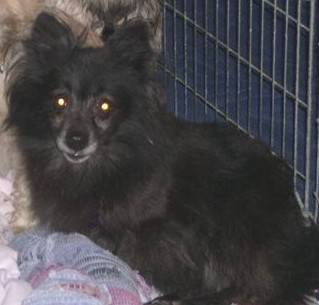

1 [0.51125067 0.4887493 ]


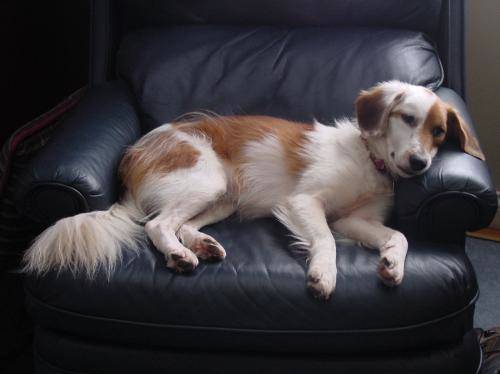

0 [0.5112679  0.48873204]


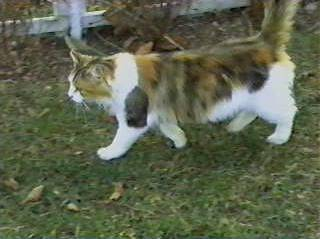

0 [0.51376146 0.48623848]


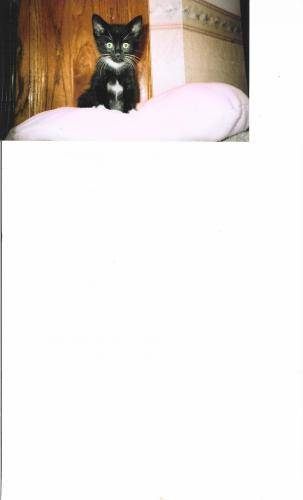

In [54]:
uncertainty = np.abs(all_proba[:, 1] - 0.5)
most_uncertain = np.argsort(uncertainty)[:n_view]

for x in most_uncertain:
    print(dsets['valid'].imgs[x][1], all_proba[x, :])
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

# Conclusion

What did we do in the end? We probably killed a fly with a sledgehammer!

In our case, the sledgehammer is VGG pretrained on ImageNet, a dataset containing a lot of pictures of cats and dogs. Indeed, we saw that without modification the network was able to predict dog and cat breeds. Hence, it is not very surprising that the features computed by VGG are very accurate for our classification task. In the end, we need to learn only the parameters of the last linear layer, i.e., 8,194 parameters (do not forget the bias $2\times 4096+2$). Indeed, this can be done on CPU without any problem.

Nevertheless, this example is still instructive as it shows all the necessary steps in a deep learning project. Here we did not struggle with the learning process of a deep network, but we did all the preliminary engineering tasks:
 
- downloading a dataset, 
- setting up the environment to use a GPU, 
- preparing the data, 
- use a pretrained model
- retrain with a new layer on a different task...

These steps are essential in any deep learning project and a necessary requirement before having fun playing with network architectures and understanding the learning process.